# Run `my_testbench_3DHI_study_phase1_2D_0619` from YAML config

This notebook runs the Python port using a standalone YAML configuration (no Excel input).


In [173]:
from pathlib import Path
import sys

cwd = Path.cwd().resolve()
base = cwd if (cwd / 'pdn').exists() else cwd.parent
sys.path.insert(0, str(base))

CONFIG = base / 'configs/3dhi_phase1_2d.yaml'
OUTPUT = base / 'results_3dhi_phase1_2d'

print('Project root:', base)
print('Config:', CONFIG)
print('Output:', OUTPUT)


Project root: /Users/seungminwoo/Library/Mobile Documents/com~apple~CloudDocs/Professional/02-Workspace/02-PDN_Bakir/fromMadison/3DICE_PDN/MATLAB Code/3D_PDN_python
Config: /Users/seungminwoo/Library/Mobile Documents/com~apple~CloudDocs/Professional/02-Workspace/02-PDN_Bakir/fromMadison/3DICE_PDN/MATLAB Code/3D_PDN_python/configs/3dhi_phase1_2d.yaml
Output: /Users/seungminwoo/Library/Mobile Documents/com~apple~CloudDocs/Professional/02-Workspace/02-PDN_Bakir/fromMadison/3DICE_PDN/MATLAB Code/3D_PDN_python/results_3dhi_phase1_2d


Using API module: /Users/seungminwoo/Library/Mobile Documents/com~apple~CloudDocs/Professional/02-Workspace/02-PDN_Bakir/fromMadison/3DICE_PDN/MATLAB Code/3D_PDN_python/pdn/api.py


Die X size:    2.500e-03 m
Die Y size:    2.500e-03 m
Die area:    6.250e-06 m2
Chip TSV Nbundle:    1.600e+01
ubump pitch (x and y):    5.000e-05 m
ubump diameter:    2.000e-05 m
C4 diameter:    7.500e-05 m
C4 pitch (x and y):    1.500e-04 m
Number of metal layers: [4. 4.]
TSV diameter:    1.000e-06 m
Chip #1 could have 2500 power bumps
Chip #1 could have 2550 ground bumps
Chip #1 could have 289 power c4 bumps
Chip #1 could have 289 ground c4 bumps
Package has 72 power bumps
Package has 81 ground bumps
Chip #1 actually has 2500 power bumps
Chip #1 actually has 2550 ground bumps
Chip #1 actually has 289 power c4 bumps
Chip #1 actually has 289 ground c4 bumps
Chip #1, Die #1 has uniform power map, skipped
chip 1, BGA number: 72.0
total power loss: 0.02
chip 1, BGA number: 81.0
total power loss: 0.02
chip1 Di

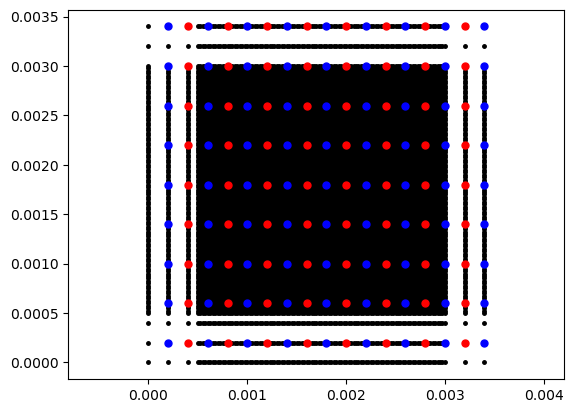

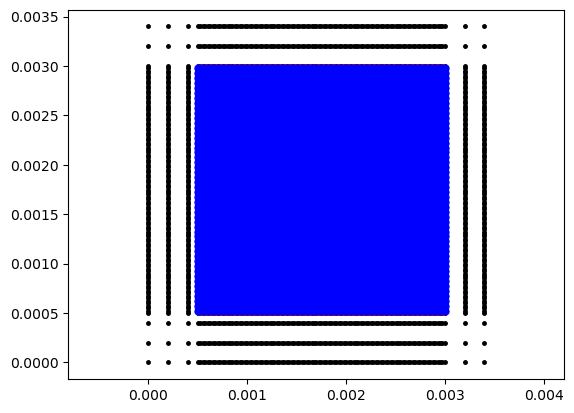

<Figure size 640x480 with 0 Axes>

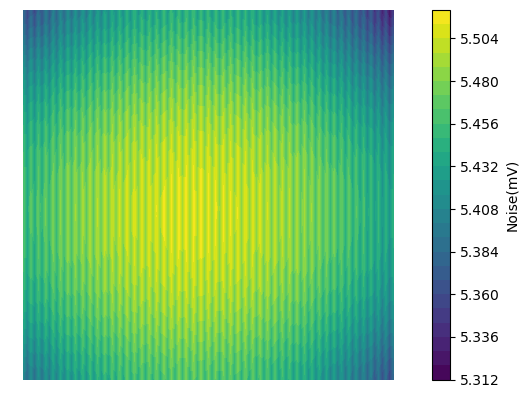

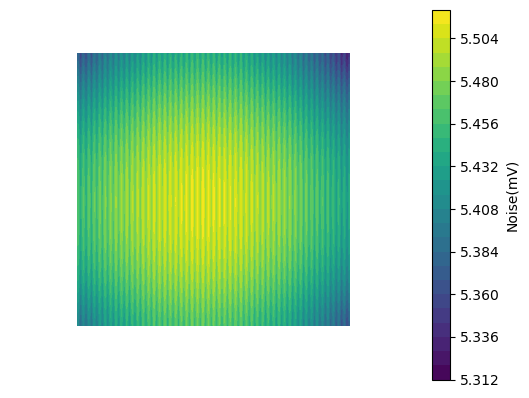

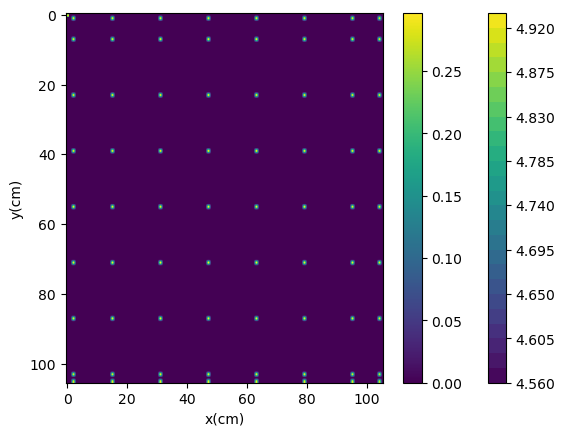

In [174]:
import importlib
import matplotlib.pyplot as plt
import numpy as np

import pdn.api as pdn_api
pdn_api = importlib.reload(pdn_api)

print('Using API module:', pdn_api.__file__)
system, chip_list = pdn_api.run_3dhi_phase1_2d_from_config(str(CONFIG), output_dir=str(OUTPUT))


chip1die1 max noise (mV): 5.51605091256341
Pkg max noise (mV): 4.924287085705315


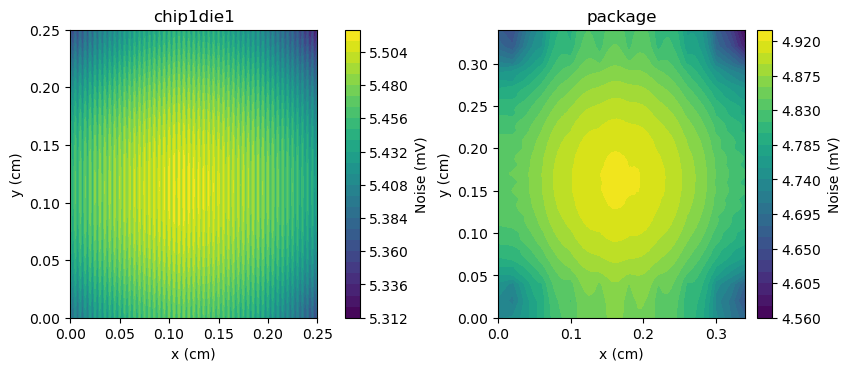

In [175]:
def load_frame(path, nx, ny):
    data = np.fromfile(path, dtype=np.float64)
    expected = nx * ny
    if data.size != expected:
        raise ValueError(f'Unexpected size in {path}: {data.size} (expected {expected})')
    return data.reshape(nx, ny).T

chip = chip_list[0]
die_files = sorted(OUTPUT.glob('chip1die*.txt'))
if not die_files:
    raise FileNotFoundError(f'No die result files found in {OUTPUT}')

die_maps = [(f.stem, load_frame(f, chip.Nx, chip.Ny)) for f in die_files]
pkg = load_frame(OUTPUT / 'pkg', system.pkg.Nx, system.pkg.Ny)

n_plots = len(die_maps) + 1
fig, ax = plt.subplots(1, n_plots, figsize=(4.2 * n_plots, 3.6), constrained_layout=True)
if n_plots == 1:
    ax = [ax]

for idx, (name, data) in enumerate(die_maps):
    im = ax[idx].contourf(np.asarray(chip.Xmesh) * 100, np.asarray(chip.Ymesh) * 100, np.abs(data) * 1000, 30)
    ax[idx].set_title(name)
    ax[idx].set_xlabel('x (cm)')
    ax[idx].set_ylabel('y (cm)')
    fig.colorbar(im, ax=ax[idx], label='Noise (mV)')

im = ax[-1].contourf(np.asarray(system.pkg.Xmesh) * 100, np.asarray(system.pkg.Ymesh) * 100, np.abs(pkg) * 1000, 30)
ax[-1].set_title('package')
ax[-1].set_xlabel('x (cm)')
ax[-1].set_ylabel('y (cm)')
fig.colorbar(im, ax=ax[-1], label='Noise (mV)')

for name, data in die_maps:
    print(f'{name} max noise (mV):', float(np.max(np.abs(data)) * 1000))
print('Pkg max noise (mV):', float(np.max(np.abs(pkg)) * 1000))
